In [ ]:
!pip install pandas
!pip install numpy
!pip install faiss-cpu
!pip install sentence-transformers
!pip install langid

In [16]:
import glob
import pickle
import pandas as pd
import numpy as np
import langid
import faiss
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.cluster import KMeans

data_path = "./data"

sns.set_theme()
%matplotlib inline

# Introdução

### Busca Semantica

A busca semântica busca melhorar a precisão dos resultados, entendendo o conteúdo da consulta na pesquisa. Em contraste com os mecanismos de pesquisa tradicionais, que só encontram documentos com base em correspondências lexicais, a pesquisa semântica também pode encontrar sinônimos.

### Como é feito?

A ideia por trás da pesquisa semântica é incorporar todas as entradas do corpus (a.k.a. coleção de dados), sejam sentenças, parágrafos ou documentos, em um espaço vetorial. No momento da pesquisa, a consulta é inserida no mesmo espaço vetorial e os embeddings mais próximos do seu corpus são encontrados. Essas entradas devem ter uma alta sobreposição semântica com a consulta.

![img01](./img/SemanticSearch.png)

### O que é Word Embedding?

Inicialmente, é preciso transformar o texto em uma informação numérica, mais especificamente um vetor. Existem algumas formas de se fazer isso, uma delas é definir cada palavra através de escalas representando alguma informação sobre essa palavra.

![img02](./img/emb01.png)
![img03](./img/emb02.png)

# Dataframe

In [41]:
data_files = glob.glob('./dataset/*.pkl')
li = []

for filename in data_files:
    df = pd.read_pickle(filename)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt13939432,tvEpisode,Episode #1.1,Episode #1.1,0,2021,\N,\N,"Music,Talk-Show"
1,tt13939434,tvEpisode,Ep 31,Ep 31,0,1997,\N,\N,"Drama,History"
2,tt13939436,tvEpisode,Knit It to Win It,Knit It to Win It,0,2021,\N,\N,Reality-TV
3,tt13939438,tvEpisode,Episode #1.2,Episode #1.2,0,2021,\N,\N,"Music,Talk-Show"
4,tt1393943,tvEpisode,RFC II: Revenge of the Warriors,RFC II: Revenge of the Warriors,0,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...
8468610,tt10158948,tvEpisode,Episode #1.228,Episode #1.228,0,2011,\N,\N,Drama
8468611,tt1015894,tvEpisode,Episode #1.6,Episode #1.6,0,2003,\N,\N,Documentary
8468612,tt10158950,short,My Father My King,My Father My King,0,2019,\N,15,"Drama,Short"
8468613,tt10158952,tvEpisode,Episode #1.229,Episode #1.229,0,2011,\N,\N,Drama


# Pré-Processamento

In [42]:
df.drop(['isAdult','endYear'], axis=1, inplace=True)
df.replace(r'\N', np.NaN, inplace=True)
df.dropna(subset=['startYear'], inplace=True)
df.dropna(subset=['genres'], inplace=True)
df['startYear'] = df['startYear'].astype(int)

df.drop(df.loc[df['titleType'] != 'movie'].index, inplace=True)
df.drop(df.loc[(df['startYear'] < 2010) | (df['startYear'] > 2021)].index, inplace=True)
df.drop(df.loc[df['genres'].str.contains("Documentary")].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt13939540,movie,Nandeesha,Nandeesha,2012,NaN,Drama
1,tt13939676,movie,Sri Chowdeshwari Devi Mahime,Sri Chowdeshwari Devi Mahime,2012,NaN,Drama
2,tt13939738,movie,Hosa Prema Purana,Hosa Prema Purana,2012,NaN,Drama
3,tt13939774,movie,See You,See You,2012,NaN,Drama
4,tt13939944,movie,Kamsale Kaisale,Kamsale Kaisale,2012,90,Drama
...,...,...,...,...,...,...,...
119848,tt10157796,movie,Menka Urvashi,Menka Urvashi,2019,149,Drama
119849,tt10157810,movie,Fjols til Fjells,Fjols til Fjells,2020,87,Comedy
119850,tt10157842,movie,Single 2,Single 2,2019,128,"Comedy,Romance"
119851,tt10158628,movie,Tokan,Tokan,2013,83,"Action,Crime"


Text(0, 0.5, 'Movies')

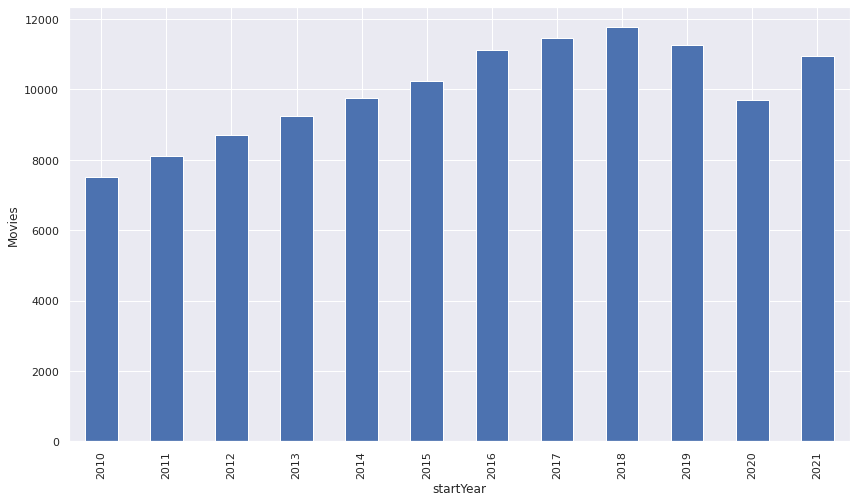

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

ax = df.groupby('startYear').size().plot.bar()
ax.set_ylabel('Movies')

 ##  Removendo títulos que não estão em inglês com o langID

 - LangID, standalone Language Identification
 - Pre-treinado com 97 linguagens.

 > langid.py is trained over a naive Bayes clas-siﬁer with a multinomial event model (McCallumand Nigam, 1998), over a mixture of byte n-grams(1≤n≤4). One key difference from conventionaltext categorization solutions is that langid.py was designed to be used off-the-shelf.

 [https://www.researchgate.net/publication/262370471_Langidpy_An_off-the-shelf_language_identification_tool](https://www.researchgate.net/publication/262370471_Langidpy_An_off-the-shelf_language_identification_tool)

In [44]:
%%time

def detect_language(doc):
    lang, log_prob = langid.classify(doc)
    if lang != 'en':
        return np.nan
    return doc

df['primaryTitle'] = df['primaryTitle'].apply(detect_language)
df.dropna(subset=['primaryTitle'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

CPU times: user 20min 14s, sys: 11min 30s, total: 31min 44s
Wall time: 12min 14s


,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt13939774,movie,See You,See You,2012,NaN,Drama
1,tt13940578,movie,Gokula Krishna,Gokula Krishna,2012,NaN,Drama
2,tt13941102,movie,The Corsicana Eight,The Corsicana Eight,2021,NaN,Comedy
3,tt1394211,movie,Helena from the Wedding,Helena from the Wedding,2010,89,"Comedy,Drama"
4,tt1394240,movie,No Limit Kids: Much Ado About Middle School,No Limit Kids: Much Ado About Middle School,2010,91,"Comedy,Family"
...,...,...,...,...,...,...,...
82800,tt10157748,movie,Ave Rara,Ave Rara,2019,45,Drama
82801,tt10157796,movie,Menka Urvashi,Menka Urvashi,2019,149,Drama
82802,tt10157842,movie,Single 2,Single 2,2019,128,"Comedy,Romance"
82803,tt10158628,movie,Tokan,Tokan,2013,83,"Action,Crime"


## Salvando o dataframe pré-processado

In [45]:
df.to_pickle(f'{data_path}/data_pre.pkl')

# SentenceTransformers

SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. The initial work is described in our paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.

In [46]:
%%time
model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')

CPU times: user 1.8 s, sys: 913 ms, total: 2.71 s
Wall time: 13.7 s


In [47]:
%%time
embedding_cache = f'{data_path}/embedding_cache.pkl'

if not os.path.exists(embedding_cache):
    df = pd.read_pickle(f'{data_path}/data_pre.pkl')
    print('Encoding... coffee time!')
    sentences = [df.originalTitle[x] for x in range(df.shape[0])]
    sentence_embeddings = model.encode(sentences)
    sentence_embeddings = np.asarray(sentence_embeddings.astype('float32'))
    print('Embedding.shape: {}'.format(sentence_embeddings.shape))

    print('Saving...')
    with open(embedding_cache, 'wb') as f:
        pickle.dump(sentence_embeddings, f)

else:
    print('Loading...')
    with open(embedding_cache, 'rb') as f:
        sentence_embeddings = pickle.load(f)
    print('Embedding.shape: {}'.format(sentence_embeddings.shape))

Encoding... coffee time!
Embedding.shape: (82805, 768)
Saving...
CPU times: user 9min 50s, sys: 4.5 s, total: 9min 54s
Wall time: 9min 55s


# Faiss (Gerando o index)

Facebook AI Similarity Search (Faiss), permite uma busca eficiente por similaridade. Dado um conjunto de vetores, podemos indexá-los usando Faiss - então usando outro vetor (o vetor de consulta ), procuramos os vetores mais semelhantes dentro do índice. O Faiss não apenas permite construir um índice e pesquisar, mas também acelera tempos de pesquisa a níveis melhores de desempenho por neio do uso da GPU.

![img02](./img/similarity-search-indexes3.png)
![img03](./img/similarity-search-indexes4.png)

- IndexFlatL2 usa a distancia Euclediana;
- IndexFlatIP utiliza o produto da distancia.

In [56]:
%%time
index_cache = f'{data_path}/sentences.index'
d = sentence_embeddings.shape[1] #768 all-mpnet-base-v2

def generate_index(data):
    index = faiss.IndexIDMap(faiss.IndexFlatIP(d))
    ids = np.array(range(0, len(data)))
    ids = np.asarray(ids.astype('int64'))
    index.add_with_ids(sentence_embeddings, ids)
    print('Saving... coffee time!')
    faiss.write_index(index, index_cache)

if not os.path.exists(index_cache):
    generate_index(df)

else:
    print('Loading...')
    index = faiss.read_index(index_cache)

Saving... coffee time!
CPU times: user 143 ms, sys: 995 ms, total: 1.14 s
Wall time: 2.27 s


# Busca

In [58]:
df = pd.read_pickle(f'{data_path}/data_pre.pkl')
k = 5

def search(query):
    query_vector = model.encode([query])
    top_k = index.search(query_vector, k)
    results = top_k[1].tolist()[0]
    return df.iloc[results]

#query = "Space Fights with no sound"
query = input()
print('search: {}'.format(query))
%time search(query)

search: super heroes
CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 143 ms


,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
525,tt14087490,movie,Super Heroes: The Movie,Super Heroes: The Movie,2021,80,Romance
41391,tt6386564,movie,Superheroines!,Superheroines!,2017,NaN,Action
48723,tt12142502,movie,Super Senior Heroes,Super Senior Heroes,2020,NaN,Drama
80431,tt11603794,movie,Superman,Superman,2020,NaN,Romance
47416,tt7493770,movie,The Supers,The Supers!,2017,99,"Action,Adventure,Comedy"


# K-Means Clusters Plot

In [117]:
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

# Considerações Finais

- Faiss permite uma busca eficiente por similaridade.
- Faiss não apenas nos permite construir um índice e pesquisar - mas também acelera os tempos de pesquisa a níveis de desempenho absurdos.
- Faiss vem com otimização de GPU embutida para qualquer máquina Linux habilitada para CUDA.
MacOS ou Windows? Bem, temos menos sorte.
- IndexFlatL2 mede a distância L2 (ou euclidiana) entre todos os pontos dados entre nosso vetor de consulta e os vetores carregados no índice. É simples, muito preciso, mas não muito rápido.
- O Faiss nos permite adicionar várias etapas que podem otimizar nossa pesquisa usando muitos métodos diferentes. Uma abordagem popular é particionar o índice em células de Voronoi.

![img01](./img/per01.png)
![img02](./img/per02.png)
![img03](./img/per03.png)
![img04](./img/voro.png)